# Import module

In [1]:
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

scvi.settings.seed = 420

Global seed set to 0
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.

In [2]:
import gc
import torch

In [5]:
import session_info
session_info.show()

# Read in data

In [3]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/PeakMatrix/Foetal_Peaks.h5ad')
adata

AnnData object with n_obs × n_vars = 167022 × 508040
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

In [6]:
adata.X.data[:10]

array([2., 2., 2., 2., 1., 1., 2., 1., 2., 2.], dtype=float32)

In [7]:
set(adata.obs.batch_key)

{'C104_Nuclei_Multiome-v1',
 'C82_Nuclei_Multiome-v1',
 'C85_Nuclei_Multiome-v1',
 'C87_Nuclei_Multiome-v1',
 'C92_Nuclei_Multiome-v1',
 'C98_Nuclei_Multiome-v1',
 'Hst33_Nuclei_Multiome-v1',
 'Hst36_Nuclei_Multiome-v1',
 'Hst39_Nuclei_Multiome-v1',
 'Hst40_Nuclei_Multiome-v1',
 'Hst41_Nuclei_Multiome-v1'}

# Subset anndata

* Only multiome
* Nuclei which are in peak adata (passed ArchR QC)
* Subsampled per fine-grained cell type (max_n=1000)

In [8]:
# read in selected nuclei id
df = pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/GEX_ATAC_comparison/subsampled_nuclei_n1000_29Dec2023.txt',
                 header=None)
nuclei_sel = pd.Index(df[0])
print(len(nuclei_sel))
nuclei_sel[:5]

44136


Index(['7089STDY13216921_BHF_F_Hea13242528_TGGGCCTAGATGGACA-1',
       '7089STDY13216921_BHF_F_Hea13242528_AAAGGCTCAGCTACGT-1',
       '7089STDY13216921_BHF_F_Hea13242528_CATCATAAGCGATACT-1',
       '7089STDY13216921_BHF_F_Hea13242528_CAGGCTATCACCAATA-1',
       '7089STDY13216921_BHF_F_Hea13242528_CTAATGTCACTTCATC-1'],
      dtype='object', name=0)

In [9]:
# subset
adata = adata[nuclei_sel]
adata

View of AnnData object with n_obs × n_vars = 44136 × 508040
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

# Modify mid grain

In [10]:
# get indices of CCS cells
a_ccs_indices = adata.obs_names[adata.obs['fine_grain'].isin(['SinoatrialNodeCardiomyocytes','AtrioventricularNodeCardiomyocytes'])]
v_ccs_indices = adata.obs_names[adata.obs['fine_grain'].isin(['VentricularConductionSystemProximal','VentricularConductionSystemDistal'])]
# modify
adata.obs['mid_grain_mod'] = adata.obs['mid_grain'].astype('str').copy()
adata.obs.replace({'mid_grain_mod':{
    'AtrialCardiomyocytes':'AtrialCardiomyocytes_plusCCS',
    'VentricularCardiomyocytes':'VentricularCardiomyocytes_plusCCS'
}},inplace=True)
adata.obs.loc[a_ccs_indices,'mid_grain_mod'] = 'AtrialCardiomyocytes_plusCCS'
adata.obs.loc[v_ccs_indices,'mid_grain_mod'] = 'VentricularCardiomyocytes_plusCCS'
adata.obs['mid_grain_mod'].value_counts()

/tmp/ipykernel_4463/1930117738.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['mid_grain_mod'] = adata.obs['mid_grain'].astype('str').copy()


LymphoidCells                        7006
Fibroblasts                          6969
VentricularCardiomyocytes_plusCCS    6531
AtrialCardiomyocytes_plusCCS         4381
MyeloidCells                         4321
MuralCells                           3103
BloodVesselEndothelialCells          3028
PericardialCells                     2187
Glia                                 1759
EndocardialCells                     1410
EpicardialCells                      1340
Neurons                              1101
LymphaticEndothelialCells            1000
Name: mid_grain_mod, dtype: int64

# Run peakVI

###### AtrialCardiomyocytes_plusCCS ######
(4381, 508040)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  4381  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     extra_categorical_covs State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │    C82_Nuclei_Multiome-v1     │          0          │
│                        │    C85_Nuclei_Multiome-v1     │          1          │
│                        │    C87_Nuclei_Multiome-v1     │          2          │
│                        │    C92_Nuclei_Multiome-v1     │          3          │
│                        │    C98_Nuclei_Multiome-v1     │          4          │
│                        │    C104_Nuclei_Multiome-v1    │          5          │
│                        │   Hst33_Nuclei_Multiome-v1    │          6          │
│                        │   Hst36_Nuclei_Multiome-v1    │          7          │
│                        │   Hst39_Nuclei_Multiome-v1    │          8          │
│                        │   Hst40_Nuclei_Multiome-v1    │          9          │
│                        │   Hst41_Nuclei_Multiome-v1    │         10          │
│                        │                               │                     │
│  adata.obs['region']   │             aorta             │          0          │
│                        │             atria             │          1          │
│                        │         atrial septum         │          2          │
│                        │      heart without node       │          3          │
│                        │             node              │          4          │
│                        │         outflow tract         │          5          │
│                        │ pulmonary arches and branches │          6          │
│                        │         whole sample          │          7          │
│                        │                               │                     │
└────────────────────────┴───────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 85/500:  17%|███████████████████████▊                                                                                                                    | 85/500 [20:37<1:40:42, 14.56s/it, loss=4.09e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 33620.641. Signaling Trainer to stop.


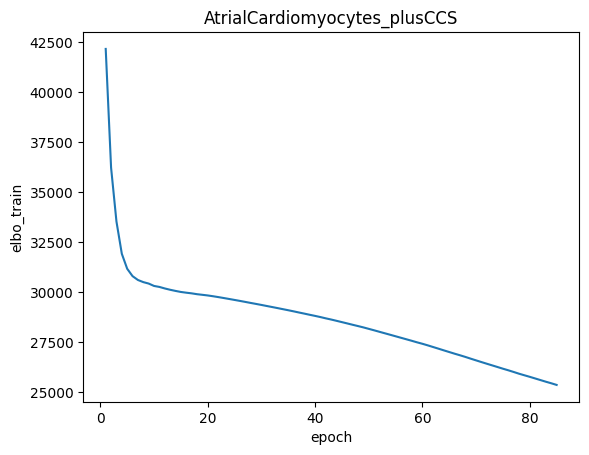

###### BloodVesselEndothelialCells ######
(3028, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  3028  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │          outflow tract          │          8          │
│                        │           pericardium           │          9          │
│                        │  pulmonary arches and branches  │         10          │
│                        │         right ventricle         │         11          │
│                        │ right ventricle and papillaries │         12          │
│                        │          whole sample           │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 87/500:  17%|████████████████████████▎                                                                                                                   | 87/500 [14:18<1:07:56,  9.87s/it, loss=3.18e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 27406.602. Signaling Trainer to stop.


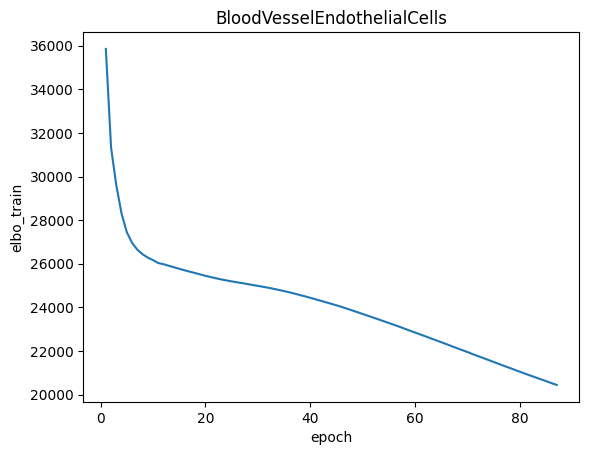

###### Glia ######
(1759, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 5 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 7 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1759  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              atria              │          1          │
│                        │          atrial septum          │          2          │
│                        │        ductus arteriosus        │          3          │
│                        │       heart without node        │          4          │
│                        │         left ventricle          │          5          │
│                        │              node               │          6          │
│                        │          outflow tract          │          7          │
│                        │           pericardium           │          8          │
│                        │  pulmonary arches and branches  │          9          │
│                        │         right ventricle         │         10          │
│                        │ right ventricle and papillaries │         11          │
│                        │          whole sample           │         12          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 103/500:  21%|████████████████████████████▊                                                                                                               | 103/500 [10:00<38:33,  5.83s/it, loss=3.11e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 27903.340. Signaling Trainer to stop.


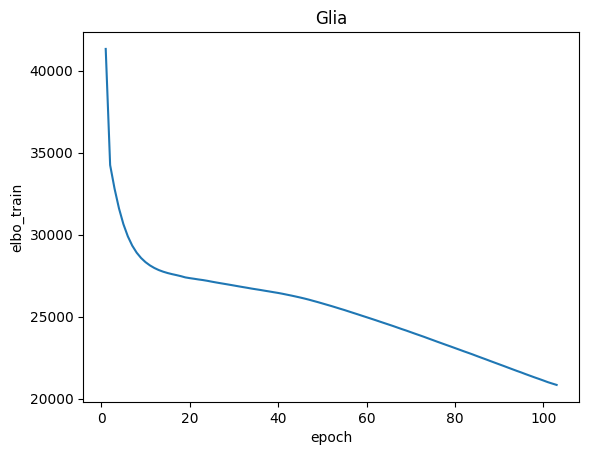

###### Neurons ######
(1101, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 5 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 9 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1101  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │       heart without node        │          5          │
│                        │              node               │          6          │
│                        │           pericardium           │          7          │
│                        │  pulmonary arches and branches  │          8          │
│                        │ right ventricle and papillaries │          9          │
│                        │          whole sample           │         10          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 101/500:  20%|████████████████████████████▎                                                                                                               | 101/500 [06:13<24:34,  3.69s/it, loss=4.52e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 42978.691. Signaling Trainer to stop.


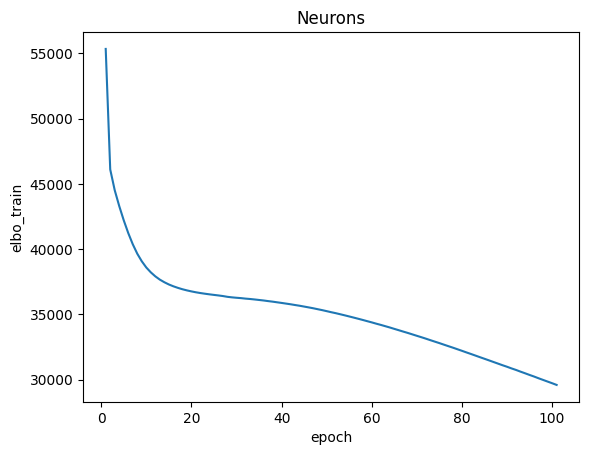

###### EndocardialCells ######
(1410, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1410  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │       heart without node        │          4          │
│                        │         left ventricle          │          5          │
│                        │              node               │          6          │
│                        │          outflow tract          │          7          │
│                        │         right ventricle         │          8          │
│                        │ right ventricle and papillaries │          9          │
│                        │          whole sample           │         10          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 106/500:  21%|█████████████████████████████▉                                                                                                               | 106/500 [08:17<30:49,  4.69s/it, loss=3.7e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 34130.070. Signaling Trainer to stop.


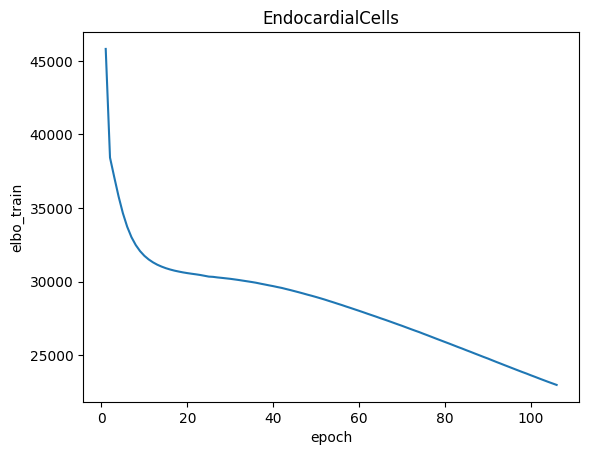

###### VentricularCardiomyocytes_plusCCS ######
(6531, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  6531  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              apex               │          0          │
│                        │              atria              │          1          │
│                        │          atrial septum          │          2          │
│                        │       heart without node        │          3          │
│                        │         left ventricle          │          4          │
│                        │              node               │          5          │
│                        │          outflow tract          │          6          │
│                        │         right ventricle         │          7          │
│                        │ right ventricle and papillaries │          8          │
│                        │          whole sample           │          9          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 88/500:  18%|████████████████████████▋                                                                                                                   | 88/500 [32:04<2:30:11, 21.87s/it, loss=4.62e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 34277.566. Signaling Trainer to stop.


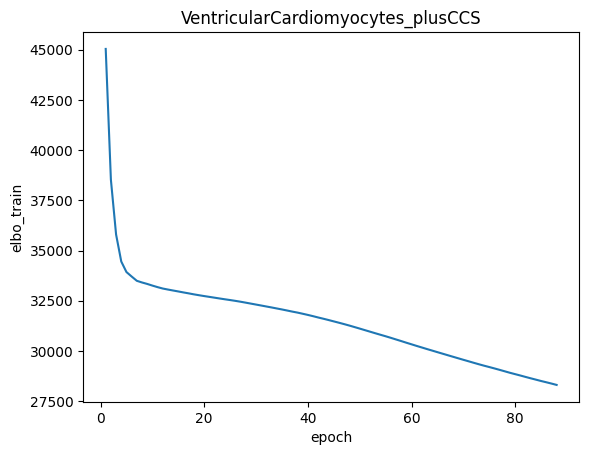

###### PericardialCells ######
(2187, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 3 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 0 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  2187  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     extra_categorical_covs State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃          Categories           ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │    C87_Nuclei_Multiome-v1     │          0          │
│                        │    C92_Nuclei_Multiome-v1     │          1          │
│                        │    C98_Nuclei_Multiome-v1     │          2          │
│                        │    C104_Nuclei_Multiome-v1    │          3          │
│                        │   Hst39_Nuclei_Multiome-v1    │          4          │
│                        │   Hst40_Nuclei_Multiome-v1    │          5          │
│                        │   Hst41_Nuclei_Multiome-v1    │          6          │
│                        │                               │                     │
│  adata.obs['region']   │             aorta             │          0          │
│                        │         atrial septum         │          1          │
│                        │       ductus arteriosus       │          2          │
│                        │      heart without node       │          3          │
│                        │         outflow tract         │          4          │
│                        │          pericardium          │          5          │
│                        │ pulmonary arches and branches │          6          │
│                        │         whole sample          │          7          │
│                        │                               │                     │
└────────────────────────┴───────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 82/500:  16%|███████████████████████▎                                                                                                                      | 82/500 [09:55<50:37,  7.27s/it, loss=3.54e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 30433.793. Signaling Trainer to stop.


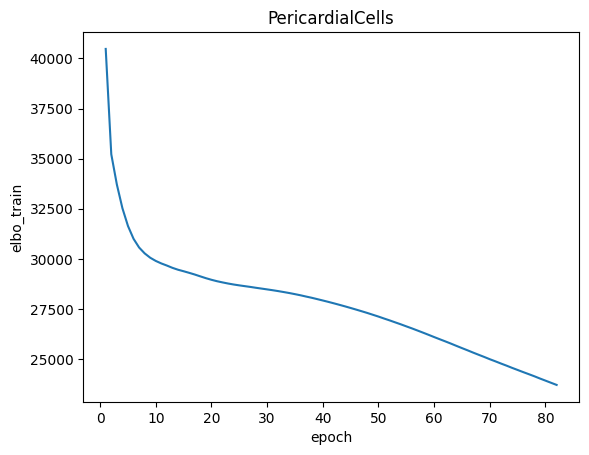

###### LymphoidCells ######
(7006, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 4 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  7006  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │    Hst33_Nuclei_Multiome-v1     │          5          │
│                        │    Hst36_Nuclei_Multiome-v1     │          6          │
│                        │    Hst39_Nuclei_Multiome-v1     │          7          │
│                        │    Hst40_Nuclei_Multiome-v1     │          8          │
│                        │    Hst41_Nuclei_Multiome-v1     │          9          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              atria              │          1          │
│                        │          atrial septum          │          2          │
│                        │        ductus arteriosus        │          3          │
│                        │       heart without node        │          4          │
│                        │         left ventricle          │          5          │
│                        │              node               │          6          │
│                        │           pericardium           │          7          │
│                        │  pulmonary arches and branches  │          8          │
│                        │         right ventricle         │          9          │
│                        │ right ventricle and papillaries │         10          │
│                        │          whole sample           │         11          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 81/500:  16%|██████████████████████▋                                                                                                                     | 81/500 [31:31<2:43:04, 23.35s/it, loss=2.75e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 21196.828. Signaling Trainer to stop.


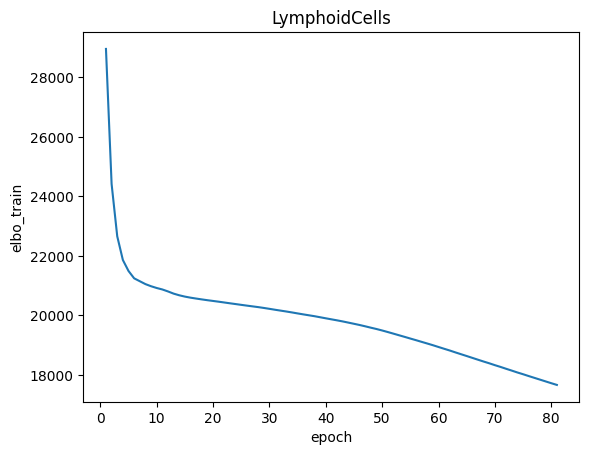

###### EpicardialCells ######
(1340, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 12 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1340  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │          outflow tract          │          8          │
│                        │           pericardium           │          9          │
│                        │  pulmonary arches and branches  │         10          │
│                        │         right ventricle         │         11          │
│                        │ right ventricle and papillaries │         12          │
│                        │          whole sample           │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 113/500:  23%|███████████████████████████████▋                                                                                                            | 113/500 [08:31<29:13,  4.53s/it, loss=4.23e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 37883.770. Signaling Trainer to stop.


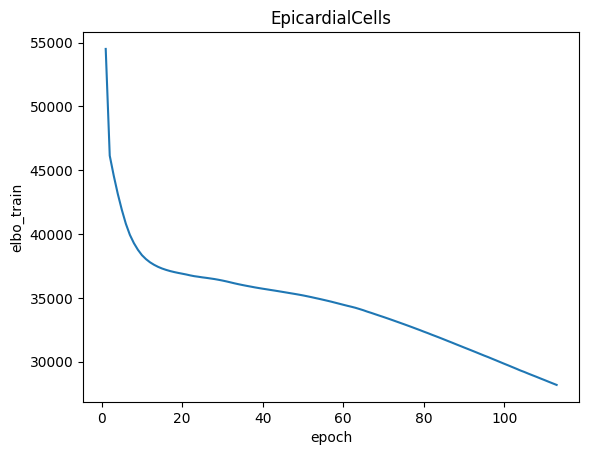

###### MuralCells ######
(3103, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 1 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  3103  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │          outflow tract          │          8          │
│                        │           pericardium           │          9          │
│                        │  pulmonary arches and branches  │         10          │
│                        │         right ventricle         │         11          │
│                        │ right ventricle and papillaries │         12          │
│                        │          whole sample           │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 90/500:  18%|█████████████████████████▏                                                                                                                  | 90/500 [15:26<1:10:22, 10.30s/it, loss=3.15e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 27358.064. Signaling Trainer to stop.


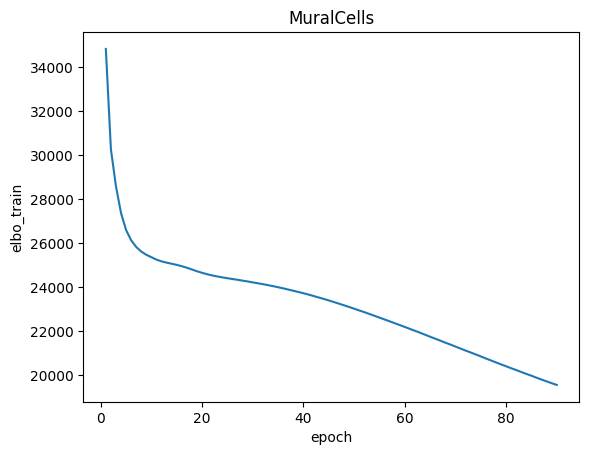

###### Fibroblasts ######
(6969, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  6969  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │          outflow tract          │          8          │
│                        │           pericardium           │          9          │
│                        │  pulmonary arches and branches  │         10          │
│                        │         right ventricle         │         11          │
│                        │ right ventricle and papillaries │         12          │
│                        │          whole sample           │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 73/500:  15%|████████████████████▍                                                                                                                       | 73/500 [28:09<2:44:43, 23.15s/it, loss=4.02e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 29998.793. Signaling Trainer to stop.


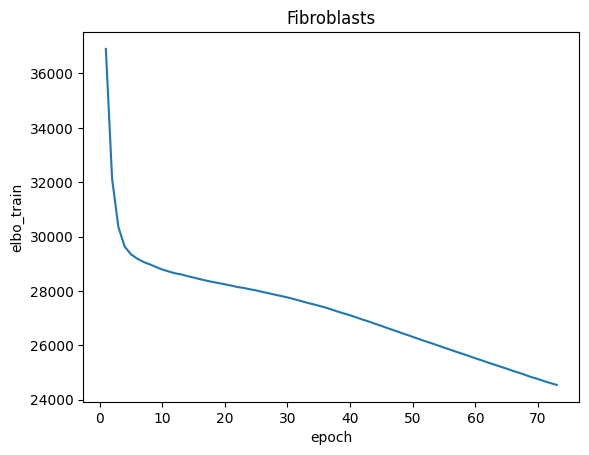

###### MyeloidCells ######
(4321, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  4321  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │          outflow tract          │          8          │
│                        │           pericardium           │          9          │
│                        │  pulmonary arches and branches  │         10          │
│                        │         right ventricle         │         11          │
│                        │ right ventricle and papillaries │         12          │
│                        │          whole sample           │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 84/500:  17%|███████████████████████▌                                                                                                                    | 84/500 [20:24<1:41:05, 14.58s/it, loss=3.46e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 29149.953. Signaling Trainer to stop.


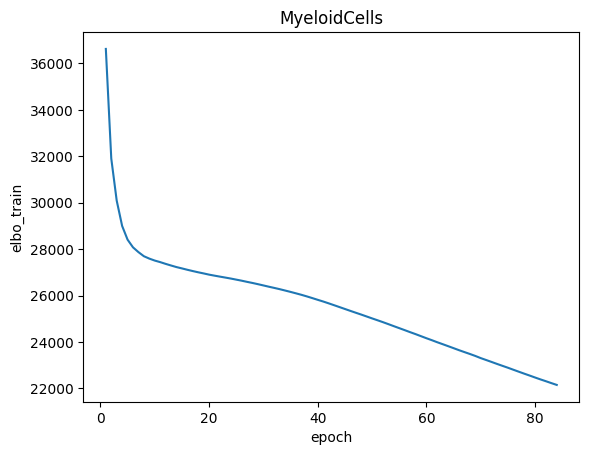

###### LymphaticEndothelialCells ######
(1000, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 5 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 1 in adata.obs['region'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key', 'region'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1000  │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                      extra_categorical_covs State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃           Categories            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │     C82_Nuclei_Multiome-v1      │          0          │
│                        │     C85_Nuclei_Multiome-v1      │          1          │
│                        │     C87_Nuclei_Multiome-v1      │          2          │
│                        │     C92_Nuclei_Multiome-v1      │          3          │
│                        │     C98_Nuclei_Multiome-v1      │          4          │
│                        │     C104_Nuclei_Multiome-v1     │          5          │
│                        │    Hst33_Nuclei_Multiome-v1     │          6          │
│                        │    Hst36_Nuclei_Multiome-v1     │          7          │
│                        │    Hst39_Nuclei_Multiome-v1     │          8          │
│                        │    Hst40_Nuclei_Multiome-v1     │          9          │
│                        │    Hst41_Nuclei_Multiome-v1     │         10          │
│                        │                                 │                     │
│  adata.obs['region']   │              aorta              │          0          │
│                        │              apex               │          1          │
│                        │              atria              │          2          │
│                        │          atrial septum          │          3          │
│                        │        ductus arteriosus        │          4          │
│                        │       heart without node        │          5          │
│                        │         left ventricle          │          6          │
│                        │              node               │          7          │
│                        │          outflow tract          │          8          │
│                        │           pericardium           │          9          │
│                        │  pulmonary arches and branches  │         10          │
│                        │         right ventricle         │         11          │
│                        │ right ventricle and papillaries │         12          │
│                        │          whole sample           │         13          │
│                        │                                 │                     │
└────────────────────────┴─────────────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 105/500:  21%|█████████████████████████████▍                                                                                                              | 105/500 [06:14<23:29,  3.57s/it, loss=3.15e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 30158.045. Signaling Trainer to stop.


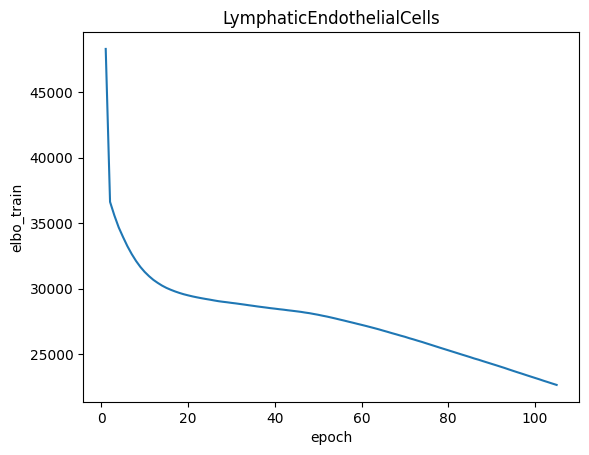

In [12]:
# adding 'region' as covariate
outdir = '/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/PeakMatrix/mid_grain_mod'

for celltype in set(adata.obs['mid_grain_mod']):
    print(f'###### {celltype} ######')
    
    # subset
    adata_sub = adata[adata.obs['mid_grain_mod']==celltype]
    print(adata_sub.shape)
    adata_sub = adata_sub.copy()
    
    # train
    scvi.model.PEAKVI.setup_anndata(adata_sub, 
                                    categorical_covariate_keys=['batch_key','region'] # added 'region'
                                   )
    pvi = scvi.model.PEAKVI(adata_sub)
    pvi.view_anndata_setup(adata_sub)
    pvi.train()
    
    # add to anndata
    latent = pvi.get_latent_representation()
    adata_sub.obsm["X_PeakVI"] = latent
    
    # save
    adata_sub.write(f'{outdir}/Foetal_{celltype}_Peaks_post-peakVI_added-cov-region_subsampled-n1000.h5ad')
    pvi.save(f'{outdir}/Foetal_{celltype}_added-cov-region_subsampled-n1000_peakVI-model', overwrite=True)
    
    # Convergency plot
    pvi.history['elbo_train']
    x = np.linspace(1, (len(pvi.history['elbo_train'])), (len(pvi.history['elbo_train'])))
    plt.plot(x, pvi.history['elbo_train'], label="train")
    plt.xlabel('epoch')
    plt.ylabel('elbo_train')
    plt.title(celltype)
    plt.show()
    
    # free up GPU
    del(pvi)
    gc.collect()
    torch.cuda.empty_cache()

###### AtrialCardiomyocytes_plusCCS ######
(4381, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  4381  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 85/500:  17%|███████████████████████▉                                                                                                                     | 85/500 [20:32<1:40:16, 14.50s/it, loss=4.1e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 33508.570. Signaling Trainer to stop.


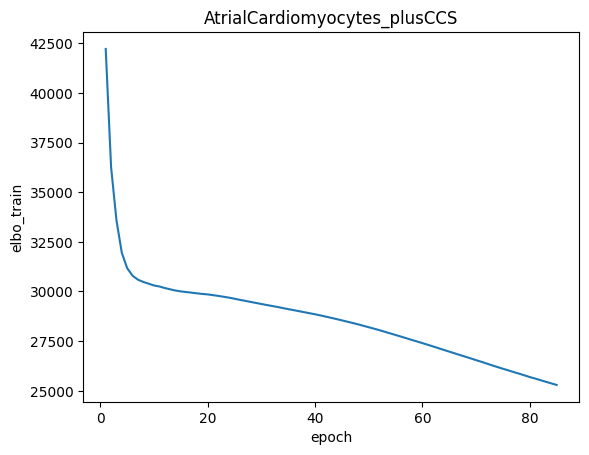

###### BloodVesselEndothelialCells ######
(3028, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  3028  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 87/500:  17%|████████████████████████▎                                                                                                                   | 87/500 [14:41<1:09:46, 10.14s/it, loss=3.24e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 27426.242. Signaling Trainer to stop.


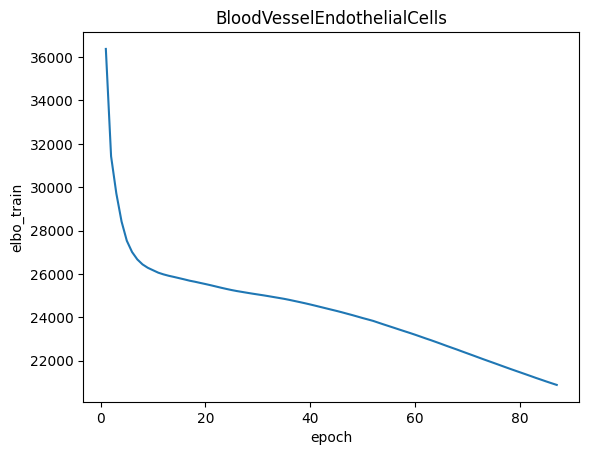

###### Glia ######
(1759, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 5 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1759  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/500:  20%|████████████████████████████                                                                                                                | 100/500 [09:48<39:14,  5.89s/it, loss=3.08e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 27881.668. Signaling Trainer to stop.


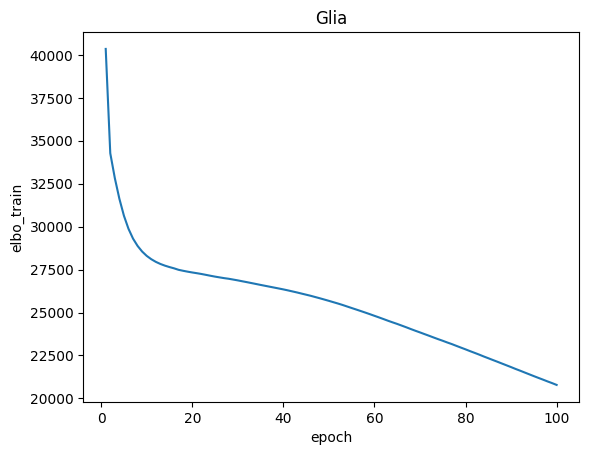

###### Neurons ######
(1101, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 5 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1101  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 110/500:  22%|██████████████████████████████▊                                                                                                             | 110/500 [06:52<24:23,  3.75s/it, loss=4.47e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 42944.938. Signaling Trainer to stop.


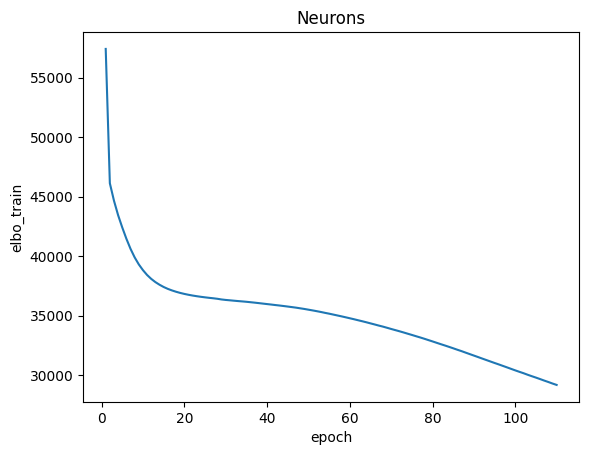

###### EndocardialCells ######
(1410, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1410  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 107/500:  21%|█████████████████████████████▉                                                                                                              | 107/500 [08:28<31:07,  4.75s/it, loss=3.81e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 34209.277. Signaling Trainer to stop.


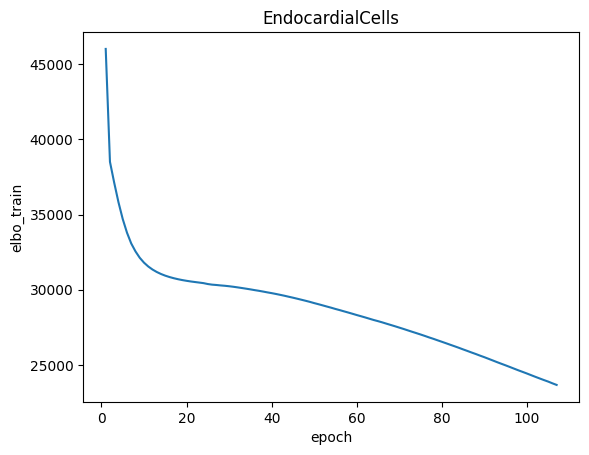

###### VentricularCardiomyocytes_plusCCS ######
(6531, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  6531  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 82/500:  16%|██████████████████████▉                                                                                                                     | 82/500 [30:02<2:33:06, 21.98s/it, loss=4.66e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 34396.367. Signaling Trainer to stop.


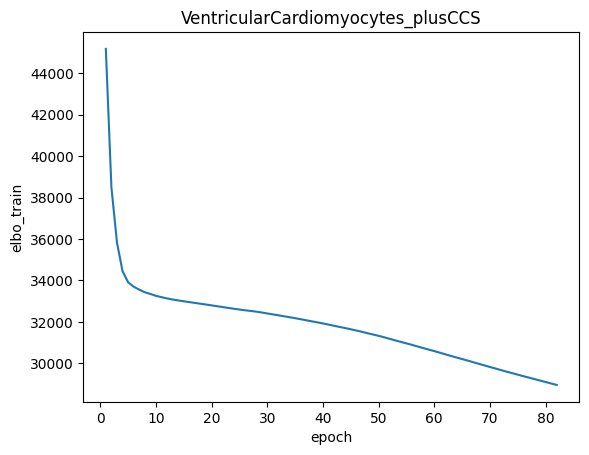

###### PericardialCells ######
(2187, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 3 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  2187  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C87_Nuclei_Multiome-v1  │          0          │
│                        │  C92_Nuclei_Multiome-v1  │          1          │
│                        │  C98_Nuclei_Multiome-v1  │          2          │
│                        │ C104_Nuclei_Multiome-v1  │          3          │
│                        │ Hst39_Nuclei_Multiome-v1 │          4          │
│                        │ Hst40_Nuclei_Multiome-v1 │          5          │
│                        │ Hst41_Nuclei_Multiome-v1 │          6          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 89/500:  18%|█████████████████████████▎                                                                                                                    | 89/500 [10:57<50:34,  7.38s/it, loss=3.53e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 30579.912. Signaling Trainer to stop.


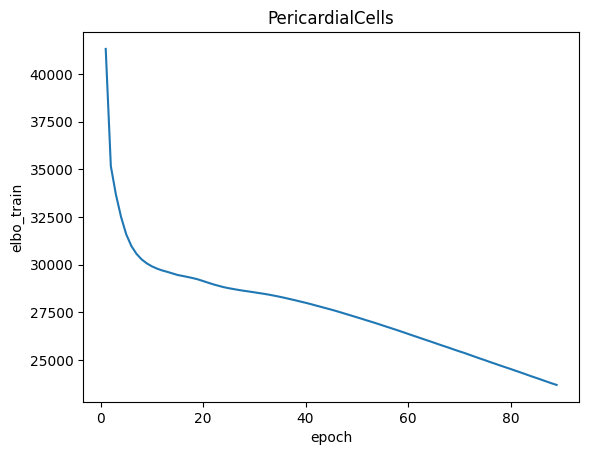

###### LymphoidCells ######
(7006, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 4 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  7006  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ Hst33_Nuclei_Multiome-v1 │          5          │
│                        │ Hst36_Nuclei_Multiome-v1 │          6          │
│                        │ Hst39_Nuclei_Multiome-v1 │          7          │
│                        │ Hst40_Nuclei_Multiome-v1 │          8          │
│                        │ Hst41_Nuclei_Multiome-v1 │          9          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 82/500:  16%|██████████████████████▉                                                                                                                     | 82/500 [32:31<2:45:47, 23.80s/it, loss=2.72e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 21162.615. Signaling Trainer to stop.


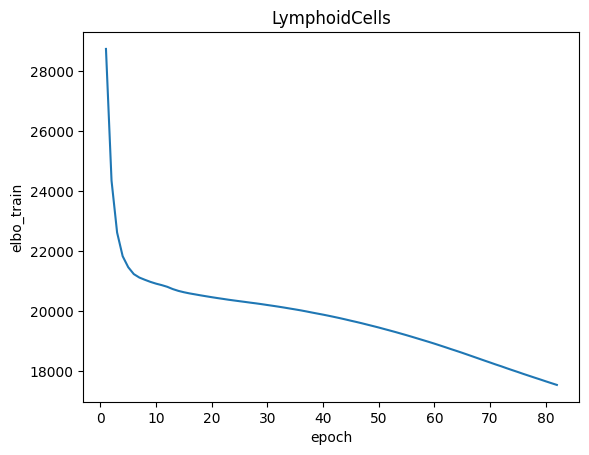

###### EpicardialCells ######
(1340, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1340  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/500:  20%|████████████████████████████                                                                                                                | 100/500 [07:39<30:37,  4.59s/it, loss=4.42e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 37964.527. Signaling Trainer to stop.


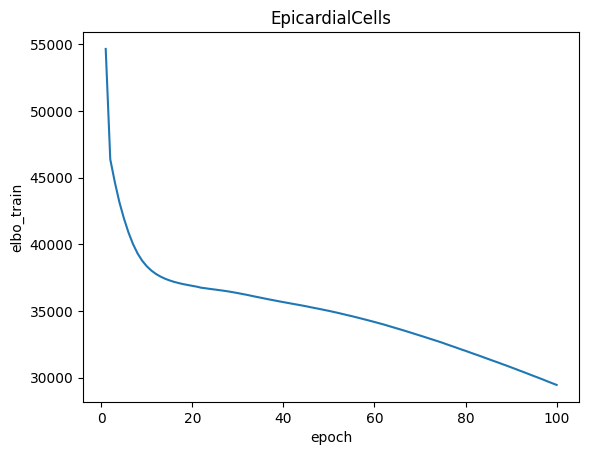

###### MuralCells ######
(3103, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  3103  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 89/500:  18%|████████████████████████▉                                                                                                                   | 89/500 [15:13<1:10:20, 10.27s/it, loss=3.14e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 27392.287. Signaling Trainer to stop.


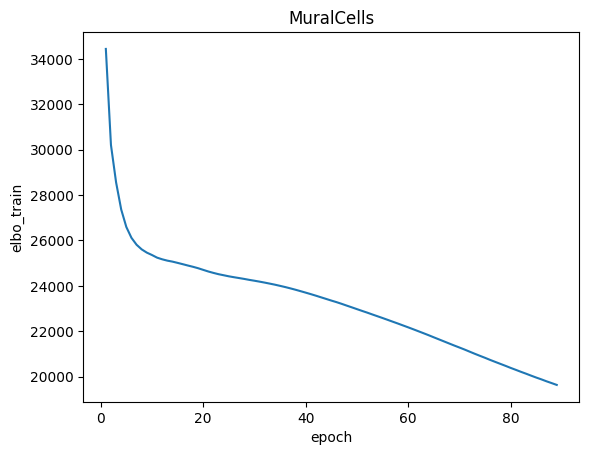

###### Fibroblasts ######
(6969, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  6969  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 79/500:  16%|██████████████████████                                                                                                                      | 79/500 [30:43<2:43:41, 23.33s/it, loss=4.04e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 30068.029. Signaling Trainer to stop.


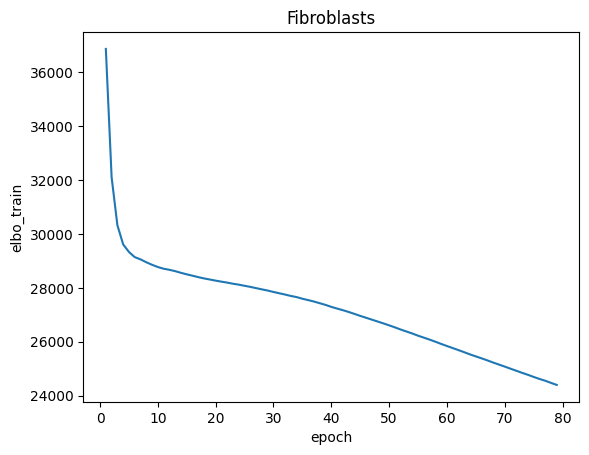

###### MyeloidCells ######
(4321, 508040)


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  4321  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 85/500:  17%|███████████████████████▊                                                                                                                    | 85/500 [20:33<1:40:20, 14.51s/it, loss=3.54e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 29083.998. Signaling Trainer to stop.


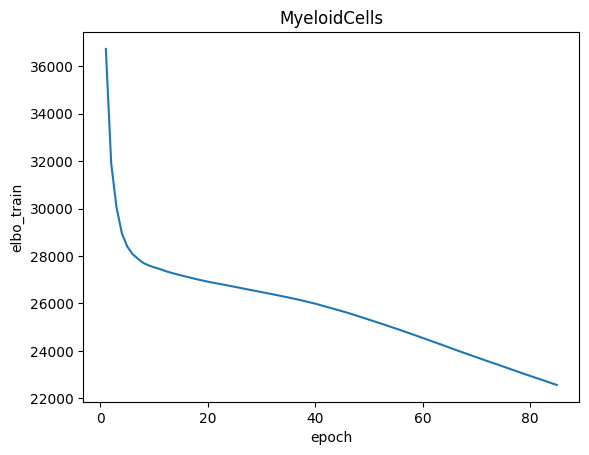

###### LymphaticEndothelialCells ######
(1000, 508040)


/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/scvi/data/_utils.py:168: UserWarning: Category 5 in adata.obs['batch_key'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


Anndata setup with scvi-tools version 0.19.0.

Setup via `PEAKVI.setup_anndata` with arguments:

{
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': None,
│   'layer': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  1000  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 508040 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ C104_Nuclei_Multiome-v1  │          5          │
│                        │ Hst33_Nuclei_Multiome-v1 │          6          │
│                        │ Hst36_Nuclei_Multiome-v1 │          7          │
│                        │ Hst39_Nuclei_Multiome-v1 │          8          │
│                        │ Hst40_Nuclei_Multiome-v1 │          9          │
│                        │ Hst41_Nuclei_Multiome-v1 │         10          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team205/kk18/miniconda3/envs/scvi0190_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 100/500:  20%|████████████████████████████                                                                                                                | 100/500 [05:55<23:41,  3.55s/it, loss=3.19e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 30174.766. Signaling Trainer to stop.


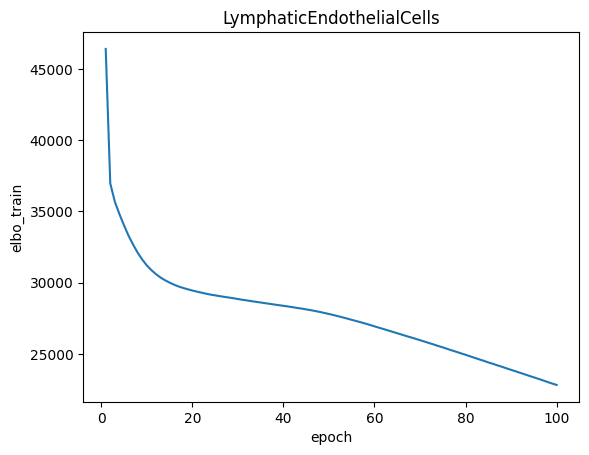

In [13]:
# NOT adding 'region' as covariate
outdir = '/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/PeakMatrix/mid_grain_mod'

for celltype in set(adata.obs['mid_grain_mod']):
    print(f'###### {celltype} ######')
    
    # subset
    adata_sub = adata[adata.obs['mid_grain_mod']==celltype]
    print(adata_sub.shape)
    adata_sub = adata_sub.copy()
    
    # train
    scvi.model.PEAKVI.setup_anndata(adata_sub, 
                                    categorical_covariate_keys=['batch_key']
                                   )
    pvi = scvi.model.PEAKVI(adata_sub)
    pvi.view_anndata_setup(adata_sub)
    pvi.train()
    
    # add to anndata
    latent = pvi.get_latent_representation()
    adata_sub.obsm["X_PeakVI"] = latent
    
    # save
    adata_sub.write(f'{outdir}/Foetal_{celltype}_Peaks_post-peakVI_subsampled-n1000.h5ad')
    pvi.save(f'{outdir}/Foetal_{celltype}_subsampled-n1000_peakVI-model', overwrite=True)
    
    # Convergency plot
    pvi.history['elbo_train']
    x = np.linspace(1, (len(pvi.history['elbo_train'])), (len(pvi.history['elbo_train'])))
    plt.plot(x, pvi.history['elbo_train'], label="train")
    plt.xlabel('epoch')
    plt.ylabel('elbo_train')
    plt.title(celltype)
    plt.show()
    
    # free up GPU
    del(pvi)
    gc.collect()
    torch.cuda.empty_cache()